<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_efficientnet_b3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Efficientnet_b3a

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

In [ ]:
trainPath = Path('dataset')

In [ ]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=16
db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = db.dataloaders(trainPath, bs=bs)

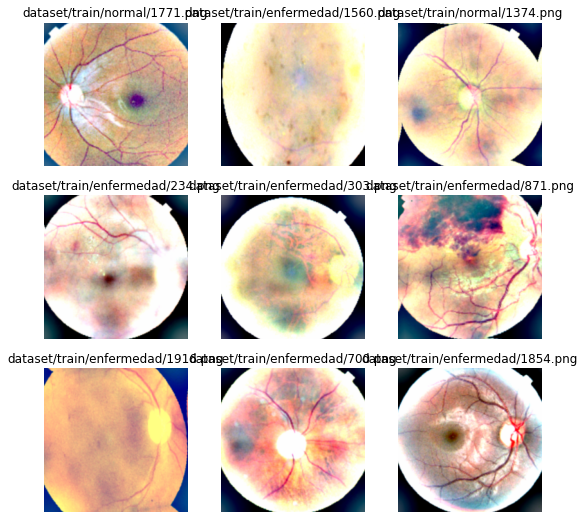

In [ ]:
dls.show_batch()

In [ ]:
!pip install wwf
!pip install nbdev

In [ ]:
from wwf.utils import *
from wwf.vision.timm import *

In [ ]:
learn = timm_learner(dls, 'efficientnet_b3a', metrics=[error_rate, accuracy], cbs=[])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,accuracy,time


KeyError: ignored

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

KeyError: ignored